# Playing Around With Logistic Regression 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import mscl.plotting
import pandas as pd
import mscl.mcmc
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

## The problem 

The purpose of this notebook is to investigate the validity of using logistic regression as a manner of predicting survival probability using channel copy number as a predictor variable. The primary assumption of logistic regression is that there is a smooth, linear increase in the log-odds probability of survival with increasing channel number,

$$
\log {p \over 1 - p} = \beta_0 + \beta_1N_\text{channels}, \tag{1}
$$

where $P$ is the probability of survival, $\beta_0$ is the intercept or the log-odds probability of survival in the case where $N_\text{channels} = 0$, and $\beta_1$ is the linear increase in the log-odds probability of survival when moving from $N_\text{channels} \rightarrow N_\text{channels} + 1$. Solving for the probability $P$ yeilds a very familiar form of 

$$
p = \left(1 + \exp\left[-\beta_0 - \beta_1N_\text{channels}\right]\right)^{-1}. \tag{2}
$$

Heun Jin is (rightfully) concerned that logistic regression may be biasing our estimates of survival probability by forcing the probability to go to 1. He's right in that it *must* go to 1 at some point, but that doesn't mean it has to go to 1 over a physiologically relevant scale. 

To show this point, I will generate a series of fake data which has a known mixed probability of surviving (1.0) or dying (0.0) and then estimate the probability using logistic regression.



## Generating the Data Set 

It will be good to have a few separate regions of our fake channel copy number space that are a delta function at a single number. Below, I set up a range of channel copy numbers and probabilities for each bin.  

In [23]:
# Define the range of channel copy numbers
bins = np.arange(1, 100, 5)
prob = [0, 0, 0, 0.1, 0.4, 0.5, 0.6, 0.6, 0.6, 0.7,
       0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 1, 1, 1]

# Set the number of data points to draw for each bin. 
n_draws = 100

# Set up the data frame. 
df = pd.DataFrame([], columns=['draw', 'bin_no', 'true_prob'])
for i, b in enumerate(bins): 
    # Draw the entries.
    draws = np.random.binomial(1, prob[i], size=n_draws)
    bin_no = np.array([b] * n_draws)
    true_prob = np.array([prob[i]] * n_draws) 
     
    # Add to the DataFrame
    _df = pd.DataFrame(np.array([draws, bin_no, true_prob]).T, columns=['draw', 'bin_no', 'true_prob'] ) 
    
    if i==0:
        df = _df
    else:
        df = df.append(_df, ignore_index=True)

With the dataframe constructed, we can now plot the "true" probability for each bin number 

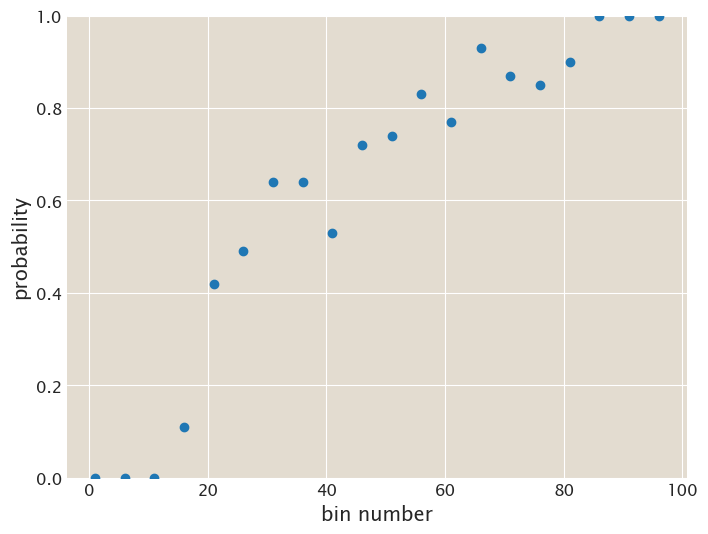

In [24]:
# Calculate the probabilites for each bin.
bin_grouped = df.groupby(['bin_no'])['draw'].sum() / n_draws

# Plot the fake data.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('bin number')
ax.set_ylabel('probability')
ax.set_ylim([0, 1])
_ = ax.plot(bin_grouped, 'o')

##  Performing Logistic Regression Using PyMC3

Logistic regression is a very common approach in the machine learning community for dictating the response of individual perceptrons to a given input. Because it is so popular, there are a ridiculous number of utilities one could use to perform logistic regression.  The most common method of estimating the values of $\beta_0$ and $\beta_1$ are through maximum likelihood estimate and then using the resulting estimates to compute an error estimate from the MLE distribution. Another attractive approach is to use MCMC which will sample our linear model given our data. I particularly like this approach because it allows for very easy marginalization of the parameter estimates and permits the calculation of an HPD.  While PyMC3 has a built-in generalized linear model sampler for logistic regression, we will define the model and functions by hand for transparency. 

### A Bayesian Model for Logistic Regression 

Since we can manipulate Eq. 1 into a function for the probability of survival, we can sample out of that model directly. To begin, we can write down Bayes' theorem, 

$$
P(p\,\vert\, \beta_0, \beta_1, [N_\text{channels}]) \propto P(\beta_0, \beta_1, [N_\text{channels}]\, \vert\, p)\propto
$$
where we have assumed independent priors for the two coefficients. A completely valid model for our likelihood is to assume that the  

### Using PyMC3 

In [25]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('draw ~ bin_no',data=df, family=pm.families.Binomial())
    trace = pm.sample(draws=10000, tune=10000, njobs=4)
    trace = mscl.mcmc.trace_to_dataframe(trace, model)
    stats = mscl.mcmc.compute_statistics(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 20000/20000 [01:45<00:00, 189.61it/s]


In [26]:
stats

,parameter,mode,hpd_min,hpd_max
0,Intercept,-2.530480,-2.796924,-2.276593
1,bin_no,0.071287,0.065491,0.077510


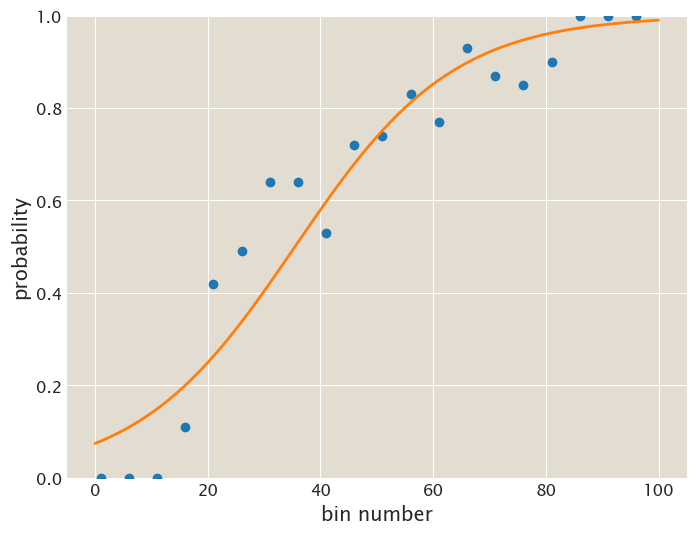

In [27]:
beta_0, beta_1 = stats['mode'].values
bin_range = np.linspace(0, 100, 300)
p = (1 + np.exp(-beta_0 - beta_1 * bin_range))**-1

# Plot the fake data.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('bin number')
ax.set_ylabel('probability')
ax.set_ylim([0, 1])
_ = ax.plot(bin_grouped, 'o', label='simulated data')
_ = ax.plot(bin_range, p, '-', label='logistic regression')